In [32]:
import os
os.environ["MOMAPS_HOME"] = "/home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps"

In [33]:
# img = next(iter(dataloader))['image'].detach().cpu().numpy()
# torch.cuda.empty_cache()
import datetime
import os
import sys




sys.path.insert(1, os.getenv("MOMAPS_HOME"))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")

import numpy as np
import pandas as pd
import logging
import  torch

from src.common.lib.utils import get_if_exists, load_config_file
from src.common.lib.model import Model
from src.common.lib.data_loader import get_dataloader
from src.datasets.dataset_spd import DatasetSPD
from torchvision.transforms import InterpolationMode
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt

%matplotlib inline
%reload_ext autoreload
%autoreload 2
%aimport

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps_Sagy/MOmaps
Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [34]:
torch.cuda.is_available()

True

In [35]:
# Utils

def get_model():
    # Load the model
    config_model = load_config_file("./src/models/neuroself/configs/model_config/TLNeuroselfB78NoDSModelConfig", 'model')


    model = Model(config_model)

    model.load_model(num_fc_output_classes=225)
    
    return model

def plot_image(img):
    plt.imshow(img[0,0,...], vmin=0, vmax=1, cmap='gray')
    
def get_image(path):
    images = np.load(path)

    images = np.transpose(images, (0,3,1,2))

#     img = images[[0]]
#     img_original = img
    
    return images
    
def get_embs(model):
    emb2 = model.model.infer_embeddings(img, 'vqvec2')
    emb2 = torch.from_numpy(emb2)
    emb2 = resize(emb2, (25,25), interpolation=InterpolationMode.NEAREST)
    print(f"emb2: {emb2.shape}")

    emb1 = model.model.infer_embeddings(img, 'vqvec1')
    emb1 = torch.from_numpy(emb1)
    print(f"emb1: {emb1.shape}")
    
    return emb1, emb2

def get_embs_ind(model, img):
    emb2 = model.model.infer_embeddings(img, 'vqind2')
    emb2 = torch.from_numpy(emb2)
    emb2 = resize(emb2, (25,25), interpolation=InterpolationMode.NEAREST)
    print(f"emb2: {emb2.shape}")

    emb1 = model.model.infer_embeddings(img, 'vqind1')
    emb1 = torch.from_numpy(emb1)
    print(f"emb1: {emb1.shape}")
    
    return emb1, emb2

def reconstruct_image(emb1, emb2):
    emb_both = torch.cat([emb2, emb1], 1)
    model.model.model.eval()
    with torch.no_grad():
        img_reconstructed = model.model.model.decoders[0](emb_both)
    print(img_reconstructed.shape)
    # plt.imshow(img_reconstructed[0,0,...])
    # plt.show()
    return img_reconstructed

def get_codebook(model):
    return model.model.model.vq_layers[0].codebook.weight.detach().cpu().numpy()

def get_ind_locations(embind, ind):
    return np.where(embind[0,0,...] == ind)

import matplotlib

def show_reco_image(img):
    plt.imshow(img[0,0,...], vmin=0, vmax=1, cmap='gray')
    plt.show()

def show_reco_and_altered_image(img, altered):
    print("Original")
    plt.imshow(img_original[0,0,...], cmap='seismic')
    plt.show()
    
    assert torch.any(img[0,0,...] != altered[0,0,...]), "The same"
    print("Reconstructed")
    plt.imshow(img[0,0,...], cmap='seismic')#, vmin=0, vmax=255)
    plt.show()
    # print("Modified Reconstructed")
    # plt.imshow(altered[0,0,...], alpha=1, cmap='seismic')#, cmap='seismic')
    # plt.show()
    
    c = torch.zeros(altered[0,0,...].shape)
    ci = torch.argwhere(img[0,0,...] != altered[0,0,...])
    for k in ci:
        c[k[0], k[1]] = 100000
    
    # ci_up = torch.argwhere(altered[0,0,...] > 10000)#torch.argwhere(torch.argwhere(img[0,0,...] != altered[0,0,...]))#
    # for k in ci_up:
    #     c[k[0], k[1]] = 100000
    # ci_down = torch.argwhere(altered[0,0,...] < -10000)#torch.argwhere(img[0,0,...] != altered[0,0,...])
    # for k in ci_down:
    #     c[k[0], k[1]] = -100000
    
    # print("Modifications")
    cmap = matplotlib.colors.ListedColormap(['white', 'yellow'])
    # plt.imshow(c, cmap=cmap)
    # plt.colorbar()
    # plt.show()
    print("Diff")
    plt.imshow(c, cmap=cmap)
    plt.show()
    print("Diff Overlay")
    plt.imshow(img[0,0,...], cmap='seismic')#, cmap='seismic')
    plt.imshow(c, alpha=0.3, cmap=cmap)
    plt.colorbar()
    plt.show()

In [36]:
model = get_model()

2023-12-17 12:00:32 INFO Creating the model
2023-12-17 12:00:32 INFO early_stop_patience=10, learn_rate=0.0002,                batch_size=4, max_epoch=100
2023-12-17 12:00:32 INFO Init model object (fc output: 225)
/home/labs/hornsteinlab/Collaboration/MOmaps/anaconda3/momaps_torch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(
2023-12-17 12:00:33 INFO Loading model /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/model_31.pt
2023-12-17 12:00:34 INFO A model has been loaded from /home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/model_31.pt


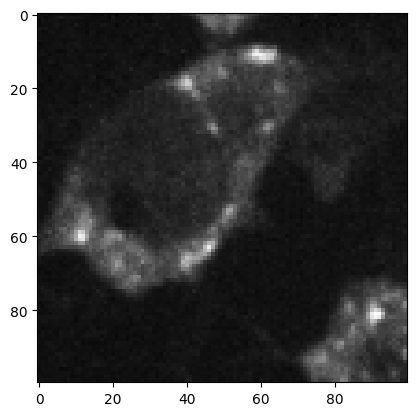

In [37]:
path = "/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch9_16bit_no_downsample/WT/stress/G3BP1/rep1_R11_w3confCy5_s1_panelA_WT_processed.npy"

images = get_image(path)
img = images[[0]]
# images = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch9_16bit_no_downsample/WT/Untreated/G3BP1/rep1_R11_w3confCy5_s201_panelA_WT_processed.npy")
plot_image(images)

In [38]:
emb1, emb2 = get_embs(model)
emb1 = emb1.cuda()
emb2 = emb2.cuda()

2023-12-17 12:00:36 INFO [infer_embeddings] output_layer = vqvec2
2023-12-17 12:00:36 INFO [infer_embeddings] output_layer = vqvec1


emb2: torch.Size([1, 576, 25, 25])
emb1: torch.Size([1, 64, 25, 25])


In [39]:
emb_ind1, emb_ind2 = get_embs_ind(model, img)


2023-12-17 12:00:37 INFO [infer_embeddings] output_layer = vqind2
2023-12-17 12:00:37 INFO [infer_embeddings] output_layer = vqind1


emb2: torch.Size([1, 9, 25, 25])
emb1: torch.Size([1, 1, 25, 25])


In [40]:
codebook = get_codebook(model)
codebook.shape

(2048, 64)

In [10]:
locs = get_ind_locations(emb_ind1, 198)
locs

(array([14, 15, 15, 16, 16, 17, 17, 17, 18, 18, 19, 20, 20, 21, 21, 22, 22,
        22]),
 array([22, 20, 21, 19, 20, 18, 19, 22, 17, 18, 17,  5, 12,  6, 13,  6,  7,
         8]))

torch.Size([1, 2, 100, 100])


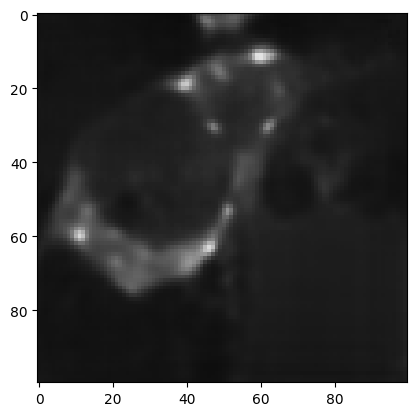

In [41]:
# Alter embeddings and reconstruct

emb1_altered = emb1.clone()
#     emb1_altered[0,:,13:,13:] = repeated_tensor*3
emb1_altered[0,:,13:,13:] = torch.zeros(64,12,12)
emb1_altered.shape

emb2_altered = emb2.clone()
#     emb2_altered[0,:,13:,13:] = torch.zeros(576,12,12)*100
# emb2_altered.shape

reco = reconstruct_image(emb1_altered, emb2_altered)
reco = reco.cpu()
show_reco_image(reco)

In [14]:
emb1_altered.shape

torch.Size([1, 64, 25, 25])

tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(-0.2730, device='cuda:0') tensor(2.3564, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
torch.Size([1, 2, 100, 100])


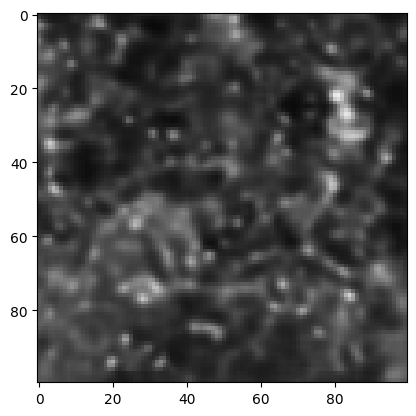

In [52]:
# All vectors


# Alter embeddings and reconstruct

emb1_altered = emb1.clone()
emb1_altered[0,...] = torch.zeros(64,25,25)
print(torch.min(emb1_altered), torch.max(emb1_altered))

for i in range(emb1_altered.shape[2]):
    for j in range(emb1_altered.shape[3]):
        emb1_altered[0,:,i,j] = torch.tensor(codebook[i*emb1_altered.shape[2]+j]).cuda()
print(torch.min(emb1_altered), torch.max(emb1_altered))

emb1_altered.shape

emb2_altered = emb2.clone()
emb2_altered[0,...] = torch.zeros(576,25,25)
print(torch.min(emb2_altered), torch.max(emb2_altered))
emb2_altered.shape

reco = reconstruct_image(emb1_altered, emb2_altered)
reco = reco.cpu()
show_reco_image(reco)

Output shape: torch.Size([1, 2, 100, 100])
target: 0.24619391560554504
tensor(-0.1333, device='cuda:0') tensor(0.1245, device='cuda:0')
torch.Size([1, 160, 100, 100])
(100, 100)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.03783099 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.06880943 0.03354515 0.        ]
 [0.         0.         0.         ... 0.0630805  0.02730566 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
False


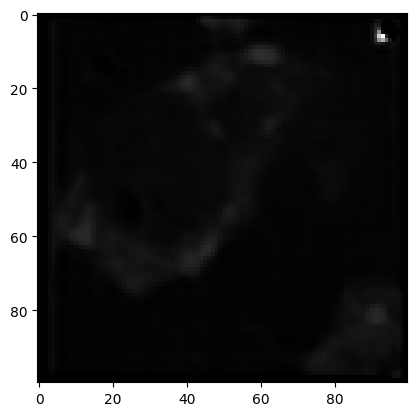

In [340]:
# GRAD CAM (the labels are the pixels)

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activations_hook)
        target_layer.register_backward_hook(self.save_gradients_hook)

    def save_activations_hook(self, module, input, output):
        self.activations = output

    def save_gradients_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, target_region):
        # Forward pass
        output, label1, label2 = self.model(input_tensor)
        
        print(f"Output shape: {output.shape}")
        
        # Zero gradients
        self.model.zero_grad()

        # Backward pass
        target = output[target_region[0], target_region[1], target_region[2], target_region[3]]
        print(f"target: {target}")
        target.backward()

        # Compute weights
        print(torch.min(self.gradients), torch.max(self.gradients))
        print(self.gradients.shape)
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        # Generate heatmap
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap = heatmap / torch.max(heatmap)

        return heatmap.detach().cpu().numpy()

    def overlay_heatmap(self, heatmap, original_image, alpha=0.5, colormap='viridis'):
        # Normalize heatmap
        heatmap = np.uint8(255 * heatmap)

        # Apply colormap
        colormap = plt.get_cmap(colormap)
        heatmap = colormap(heatmap)

        # Overlay heatmap
        heatmap = np.float32(heatmap) / 255
        overlayed_image = heatmap[..., 0] * alpha + np.float32(original_image) * (1 - alpha)

        return np.uint8(255 * overlayed_image)

# Usage
model.model.model.train()
target_layer = model.model.model.decoders[0].decoder['resrep2last']  # The layer you want to visualize
grad_cam = GradCAM(model.model.model, target_layer)

# Prepare input tensor
images = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/batch9_16bit_no_downsample/WT/stress/G3BP1/rep1_R11_w3confCy5_s1_panelA_WT_processed.npy")
images = np.transpose(images, (0,3,1,2))
input_tensor = torch.tensor(images[[0]]).float().cuda()  # Your input tensor

# Define the target pixel or region
target_region = (0,0,50, 50)

# Generate heatmap
heatmap = grad_cam.generate_heatmap(input_tensor, target_region)
print(heatmap.shape)
print(heatmap)
print((heatmap == old_heatmap).all())
old_heatmap = heatmap
# Overlay heatmap on original image (if applicable)
# original_image = images[0]  # The original image
# overlayed_image = grad_cam.overlay_heatmap(heatmap, original_image[0,...], alpha=1)

# Plotting
# plt.imshow(overlayed_image, cmap='gray', vmin=0, vmax=255)
# plt.show()

plt.imshow(heatmap, cmap='gray', vmin=0, vmax=1)
plt.show()




------------------------------------------

In [ ]:
# Utils obsolete??
def get_diff_indexes(marker='G3BP1', threshold=2.5):
    plt.bar(np.arange(len(diff.loc[marker,:])), diff.loc[marker,:])
    plt.axhline(threshold, alpha=0.3, color='red')
    plt.axhline(-threshold,  alpha=0.3, color='red')

    diff_indexes_up = diff.loc[marker,diff.loc[marker,:] >= threshold].index
    diff_indexes_down = diff.loc[marker,diff.loc[marker,:] <= -threshold].index
    return diff_indexes_up, diff_indexes_down

# diff_indexes_up, diff_indexes_down = get_diff_indexes(threshold=3)

def replace_diff_indexes_with(indx=0, codeword=None, swap=False, is_baseline=True, only_up=False, only_down=False):
    # is_baseline - if the image is stress set it to True, False otherwise (untreated)
    # swap - Swap upregualted codeword with dowregulated ones
    # index - Set to all up/downregulated codewords the i codeword from the codebook
    # codeword - Set this codeword to all up/downregulated codewords
    vq_idx = 1
    emb1_copy = emb1.clone()
    
    embind1 = model.model.infer_embeddings(img, f'vqind{vq_idx}')
    embind1 = torch.from_numpy(embind1)
    print(embind1.shape)
    
    codebook = model.model.model.vq_layers[vq_idx - 1].codebook.weight.detach().cpu().numpy()

    if not swap:
        placeholder_word = torch.from_numpy(codebook[indx]) if codeword is None else codeword
        placeholder_word.shape

    indexes_to_replace_up = np.isin(embind1[0][0].detach().cpu().numpy(), diff_indexes_up)
    indexes_to_replace_down = np.isin(embind1[0][0].detach().cpu().numpy(), diff_indexes_down)
    
    if is_baseline:
        _tmp = indexes_to_replace_up
        indexes_to_replace_up = indexes_to_replace_down
        indexes_to_replace_down = _tmp
    
    if not swap:
        placeholder_word_up = placeholder_word
        placeholder_word_down = -placeholder_word
    
    # if swap:
    #     placeholder_word_up = codebook[diff_indexes_down[0]]
        # placeholder_word_down = codebook[diff_indexes_up[0]]
    
    print(np.sum(indexes_to_replace_up), np.sum(indexes_to_replace_down))

    for i in range(emb1_copy.shape[2]):
        for j in range(emb1_copy.shape[3]):
            if indexes_to_replace_up[i,j] and not only_down:
                print(f"Here, ({i}, {j})")
                if swap:
                    placeholder_word_up = codebook[diff_indexes_down[np.random.choice(len(diff_indexes_down))]]
                    placeholder_word_up = torch.from_numpy(placeholder_word_up)
                    # print(placeholder_word_up)
                assert torch.any(emb1_copy[:,:, i,j] != placeholder_word_up), "The same"
                emb1_copy[:,:, i,j] = placeholder_word_up
            elif indexes_to_replace_down[i,j] and not only_up:
                if not swap:
                    print(f"Here Down, ({i}, {j}), {placeholder_word_down}")
                    emb1_copy[:,:, i,j] = placeholder_word_down
            # else:
            #     if not swap:
            #         emb1_copy[:,:, i,j] = torch.zeros((64,))


    # for i in range(indexes_to_replace_up.shape[0]):
    #     for j in range(indexes_to_replace_up.shape[1]):
    #         if not indexes_to_replace_up[i,j]:
    #             continue
    #         print(f"Yes, ({i},{j})")
    #         emb1_copy[:,:, i,j] = placeholder_word
            
    # for i in range(indexes_to_replace_down.shape[0]):
    #     for j in range(indexes_to_replace_down.shape[1]):
    #         if not indexes_to_replace_down[i,j]:
    #             continue
    #         print(f"Yes, ({i},{j})")
    #         emb1_copy[:,:, i,j] = -placeholder_word
    
    return emb1_copy

def highlight_codevecs_separatly():
    # is_baseline - if the image is stress set it to True, False otherwise (untreated)
    # swap - Swap upregualted codeword with dowregulated ones
    # index - Set to all up/downregulated codewords the i codeword from the codebook
    # codeword - Set this codeword to all up/downregulated codewords
    vq_idx = 1
    
    embind1 = model.model.infer_embeddings(img, f'vqind{vq_idx}')
    embind1 = torch.from_numpy(embind1)
    print(embind1.shape)
    
    # codebook = model.model.model.vq_layers[vq_idx - 1].codebook.weight.detach().cpu().numpy()

    all_indexes = np.unique(embind1[0][0].detach().cpu().numpy())
    print(len(all_indexes))
    
    
    for index in all_indexes:
        index_to_highlight = torch.argwhere(embind1[0][0] == index)
        for i in index_to_highlight:
            emb1_copy = torch.zeros_like(emb1)
            emb1_copy[:,:, i[0],i[1]] = torch.ones((64,))*10000
            r = reconstruct_image(emb1_copy, emb2)
            plt.imshow(img_original[0,0,...], cmap='gray')
            plt.imshow(r[0,0,...], alpha=0.3, cmap='seismic')
            plt.show()
            # else:
            #     if not swap:
            #         emb1_copy[:,:, i,j] = torch.zeros((64,))


    # for i in range(indexes_to_replace_up.shape[0]):
    #     for j in range(indexes_to_replace_up.shape[1]):
    #         if not indexes_to_replace_up[i,j]:
    #             continue
    #         print(f"Yes, ({i},{j})")
    #         emb1_copy[:,:, i,j] = placeholder_word
            
    # for i in range(indexes_to_replace_down.shape[0]):
    #     for j in range(indexes_to_replace_down.shape[1]):
    #         if not indexes_to_replace_down[i,j]:
    #             continue
    #         print(f"Yes, ({i},{j})")
    #         emb1_copy[:,:, i,j] = -placeholder_word
    
    # return emb1_copy
    
# emb1_altered = replace_diff_indexes_with(swap=False, is_baseline=False, codeword=torch.ones((64,))*1000000, only_down=True)
# emb1_altered.shape